# Exercise: Insights

- A Studio that produces movies asked us whether we could provide valuable (for them) insights based on our data.

- Also, our procurement team, ie the team that signs new studios and new films, asked us whether we could help them make data-driven decisions on what films to sign next.

In [225]:
import re
from datetime import datetime
import numpy as np
import pandas as pd
import dask.dataframe as dd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [233]:
movies_df = pd.read_csv("/Users/cesareressa/Documents/datasets/movies.csv")
ratings_df = pd.read_csv("/Users/cesareressa/Documents/datasets/ratings.csv")
tags_df = pd.read_csv("/Users/cesareressa/Documents/datasets/tags.csv")

In [3]:
#add dummy inisghts from expl analysis
#how many movies are rated?
len(ratings_df.movieId.unique())

#how many movies are tagged?
#number of movies with tags

len(tags_df.movieId.unique())

#how many users

#what is the oldest movie

#what is the latest movie

45981

Extract and Transform data 

In [234]:
movies_df

#add movie year column
movies_df["movie_year"] = movies_df.title.str.findall(r"\((\d\d\d\d)\)").apply(','.join) 
movies_df["movie_year"] = pd.to_numeric(movies_df.movie_year, downcast="integer")
# modify two values due to error in movie title
# movies_df.at[89398, "movie_year"] = 2017
# movies_df.at[9775250, "movie_year"] = 2017
#split movie genres and organize them into a list (will be handy later) 
movies_df["genres"] = movies_df["genres"].str.split("|")
# movies_df["genres"] = movies_df["genres"].str.replace("|", ", ", regex=True)

#create function that selects start and end time interval and appends:
#if none -> all times
#average ratings
#all views

#generate visuals
#avg ratings for top 10 movies
#views start-end time int for top 10 movies
#create function to
#get all tags for top rated movies queried

ValueError: Unable to parse string "2017,2017" at position 47763

Merge datasets

In [4]:
dd_movies = dd.read_csv("/Users/cesareressa/Documents/datasets/movies.csv")
dd_ratings = dd.read_csv("/Users/cesareressa/Documents/datasets/ratings.csv")
dd_tags = dd.read_csv("/Users/cesareressa/Documents/datasets/tags.csv")

In [5]:
dd_user_info = dd.merge(dd_ratings, dd_tags, how="left", on=["userId", "movieId"], suffixes=("_rating", "_tag"))

In [6]:
df_user_info = dd_user_info.compute()

In [7]:
#add datetime columns -
# look for seasonality - timeseries

In [37]:
dd_complete = dd.merge(df_user_info, dd_movies, how="left", on="movieId")

In [38]:
df_complete = dd_complete.compute()

In [10]:
df_complete.describe()

,userId,movieId,rating,timestamp_rating,timestamp_tag
count,2.836350e+07,2.836350e+07,2.836350e+07,2.836350e+07,8.304920e+05
mean,1.416773e+05,1.919388e+04,3.536770e+00,1.197512e+09,1.398766e+09
std,8.170236e+04,3.591059e+04,1.066656e+00,2.164155e+08,1.110469e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08,1.135429e+09
25%,7.077700e+04,1.127000e+03,3.000000e+00,1.002635e+09,1.308503e+09
50%,1.415620e+05,2.762000e+03,4.000000e+00,1.182207e+09,1.435359e+09
75%,2.121950e+05,7.360000e+03,4.000000e+00,1.427658e+09,1.492018e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09,1.537945e+09


In [41]:
#can we use dask for this?

df_complete["datetime_rating"] = pd.to_datetime(df_complete["timestamp_rating"], unit="s")
df_complete["datetime_tag"] = pd.to_datetime(df_complete["timestamp_tag"], unit="s")
df_complete["genres"] = df_complete["genres"].str.split("|")
df_complete["movie_year"] = df_complete.title.str.findall(r"\((\d\d\d\d)\)").apply(','.join)
df_complete["movie_year"] = pd.to_numeric(df_complete.movie_year, downcast="integer")

AttributeError: Can only use .str accessor with string values!

In [200]:
df_complete.movie_year.iloc[0]

'1993'

In [25]:
dataset = df_complete.copy()

#filter from start and end date

#if start is not None:

# filter dataset.datetime_rating > start date

#if end is not None:

#filter dataset.datetime_rating < end date

# return filtered dataset

def filter_start(df, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Use to filter the dataset based on time interval. 
    """
    return df.loc[(df.datetime_rating >= start_date) & (df.datetime_rating <= end_date)].sort_values(by= "datetime_rating", ascending= False)

#--

# filter production date

# filter_production_date(dataset, start_year, end_year):
# return dataset.loc[(dataset.movie_year >= start_year) & (dataset.movie_year <= end_year)]

# get_views(dataset, start, end, prod_start, prod_end)

# filtered_df = filter_startend(dataset)

# filtered_df = filter_production_date(filtered_df, prod_start, prod_end)

def filter_production_date(df, prod_start, prod_end):
    """
    Use to filter the dataset based on production movie year
    """
    return df.loc[(df.movie_year >= prod_start) & (df.movie_year <= prod_end)]

# insights_df = filtered_df.movieId.value_counts()

In [28]:
def filter_start(df: pd.DataFrame, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Use to filter the dataset based on time interval. 
    Args: df: pandas df with datetime_rating (assumed to be approximately the moment the movie has been watched), start_date, end_date.
    Returns: pandas df filtered for a defined time interval.
    """
    return df.loc[(df.datetime_rating >= start_date) & (df.datetime_rating <= end_date)].sort_values(by= "datetime_rating", ascending= False)

In [30]:
def filter_production_date(df: pd.DataFrame, prod_start: int, prod_end: int) -> pd.DataFrame:
    """
    Use to filter the dataset based on production movie years.
    Args: df: pandas df with movie titles and production movie year, prod_start: start prodcution movie year, prod_end: end production movie year.
    Returns: pandas df filter by production movie year interval.
    """
    return df.loc[(df.movie_year >= prod_start) & (df.movie_year <= prod_end)]

In [31]:
start_date = datetime(2018, 1, 1)

end_date = datetime.now()

test_df = filter_start(dataset, start_date, end_date)

In [49]:
test_df.movie_year = pd.to_numeric(test_df.movie_year, downcast="integer")

test_df

,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,title,genres,datetime_rating,datetime_tag,movie_year
3076786,82922,167780,4.0,1537945149,NaN,NaN,Superman/Shazam!: The Return of Black Adam (2010),"[Action, Animation]",2018-09-26 06:59:09,NaT,2010.0
3070001,82922,53519,4.0,1537945130,NaN,NaN,Death Proof (2007),"[Action, Adventure, Crime, Horror, Thriller]",2018-09-26 06:58:50,NaT,2007.0
24853442,280481,494,3.0,1537945127,NaN,NaN,Executive Decision (1996),"[Action, Adventure, Thriller]",2018-09-26 06:58:47,NaT,1996.0
24854350,280481,2355,3.0,1537945123,NaN,NaN,"Bug's Life, A (1998)","[Adventure, Animation, Children, Comedy]",2018-09-26 06:58:43,NaT,1998.0
24854326,280481,2294,2.0,1537945121,NaN,NaN,Antz (1998),"[Adventure, Animation, Children, Comedy, Fantasy]",2018-09-26 06:58:41,NaT,1998.0
...,...,...,...,...,...,...,...,...,...,...,...
19136327,44555,2133,2.5,1514764931,NaN,NaN,Adventures in Babysitting (1987),"[Adventure, Comedy]",2018-01-01 00:02:11,NaT,1987.0
19136036,44555,1610,3.5,1514764928,NaN,NaN,"Hunt for Red October, The (1990)","[Action, Adventure, Thriller]",2018-01-01 00:02:08,NaT,1990.0
19137193,44555,4022,4.0,1514764926,NaN,NaN,Cast Away (2000),[Drama],2018-01-01 00:02:06,NaT,2000.0
19135876,44555,1270,4.0,1514764920,NaN,NaN,Back to the Future (1985),"[Adventure, Comedy, Sci-Fi]",2018-01-01 00:02:00,NaT,1985.0


In [54]:
test1 = filter_production_date(test_df, 2010, 2020)

In [74]:
test1[test1.movieId == 73268]

,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,title,genres,datetime_rating,datetime_tag,movie_year
1983805,81924,73268,0.5,1537930729,NaN,NaN,Daybreakers (2010),"[Action, Drama, Horror, Thriller]",2018-09-26 02:58:49,NaT,2010.0
17417419,122037,73268,5.0,1537633309,NaN,NaN,Daybreakers (2010),"[Action, Drama, Horror, Thriller]",2018-09-22 16:21:49,NaT,2010.0
18324274,69860,73268,3.0,1537572236,NaN,NaN,Daybreakers (2010),"[Action, Drama, Horror, Thriller]",2018-09-21 23:23:56,NaT,2010.0
2496532,55788,73268,3.0,1537421203,NaN,NaN,Daybreakers (2010),"[Action, Drama, Horror, Thriller]",2018-09-20 05:26:43,NaT,2010.0
20280399,251441,73268,3.5,1537406394,NaN,NaN,Daybreakers (2010),"[Action, Drama, Horror, Thriller]",2018-09-20 01:19:54,NaT,2010.0
...,...,...,...,...,...,...,...,...,...,...,...
1621280,132796,73268,1.5,1515801124,NaN,NaN,Daybreakers (2010),"[Action, Drama, Horror, Thriller]",2018-01-12 23:52:04,NaT,2010.0
22900157,253708,73268,2.5,1515534502,NaN,NaN,Daybreakers (2010),"[Action, Drama, Horror, Thriller]",2018-01-09 21:48:22,NaT,2010.0
3436975,83291,73268,3.0,1515234747,NaN,NaN,Daybreakers (2010),"[Action, Drama, Horror, Thriller]",2018-01-06 10:32:27,NaT,2010.0
10144752,165954,73268,3.0,1515049963,NaN,NaN,Daybreakers (2010),"[Action, Drama, Horror, Thriller]",2018-01-04 07:12:43,NaT,2010.0


In [83]:
#aggregate views and avg ratings

# count_movies = test1.movieId.value_counts()

# count_movies = pd.DataFrame(count_movies)

# count_movies = count_movies.rename(columns={"movieId": "total_views"})

# count_movies

count_views = pd.DataFrame(test1.groupby("movieId")["movieId"].count()).rename(columns={"movieId": "total_views"})

rating_means = pd.DataFrame(ratings_df.groupby("movieId")["rating"].mean()).rename(columns={"rating": "average_rating"})

movies_df = pd.merge(movies_df, count_views, on="movieId")

movies_df = pd.merge(movies_df,  rating_means, on="movieId")



In [240]:
def aggregate_data(df):

    movies_df_copy = movies_df.copy()

    count_views = pd.DataFrame(df.groupby("movieId")["movieId"].count()).rename(columns={"movieId": "total_views"})

    rating_means = pd.DataFrame(df.groupby("movieId")["rating"].mean()).rename(columns={"rating": "average_rating"})

    movies_df_copy = pd.merge(movies_df, count_views, on="movieId")

    movies_df_copy = pd.merge(movies_df_copy,  rating_means, on="movieId")

    return movies_df_copy

In [88]:
movies_df.sort_values(by="total_views", ascending=False).head(20).plot()

,movieId,title,genres,total_views,average_rating,movie_year
89,79132,Inception (2010),"[Action, Crime, Drama, Mystery, Sci-Fi, Thrill...",4002,4.162990,2010
3234,122912,Avengers: Infinity War - Part I (2018),"[Action, Adventure, Sci-Fi]",3629,3.956709,2018
8219,176371,Blade Runner 2049 (2017),[Sci-Fi],3562,3.888662,2017
3235,122916,Thor: Ragnarok (2017),"[Action, Adventure, Sci-Fi]",3069,3.850147,2017
8418,177593,"Three Billboards Outside Ebbing, Missouri (2017)","[Crime, Drama]",3027,4.009094,2017
2239,109487,Interstellar (2014),"[Sci-Fi, IMAX]",2941,4.092869,2014
8442,177765,Coco (2017),"[Adventure, Animation, Children]",2799,4.061829,2017
6525,164179,Arrival (2016),[Sci-Fi],2436,4.019926,2016
3231,122904,Deadpool (2016),"[Action, Adventure, Comedy, Sci-Fi]",2392,3.859245,2016
3232,122906,Black Panther (2017),"[Action, Adventure, Sci-Fi]",2367,3.684026,2017


In [247]:
#create insights
def generate_plots(movies_df: pd.DataFrame, top: int=20):
    """
    Use to generate insights based on movies_df. By default, the insights will be generated based on the top 20 movies. 
    """
    fig, axs = plt.subplots(2, 1, figsize=(18, 16), sharey=False)

    axs[0].barh(movies_df.sort_values(by="total_views", ascending=False).head(top)["title"], movies_df.sort_values(by="total_views", ascending=False).head(top)["total_views"])
    axs[0].set_xlabel("Total views")
    # axs[1].barh(movies_df.sort_values(by="total_views", ascending=False).head(top)["title"], movies_df.sort_values(by="total_views", ascending=False).head(top)["average_rating"])
    # axs[1].set_xlabel("Average rating")
    axs[1].scatter(movies_df.sort_values(by="total_views", ascending=False)["average_rating"], movies_df.sort_values(by="total_views", ascending=False)["total_views"])
    axs[1].set_xlabel("average_rating")
    axs[1].set_ylabel("total_views")
    axs[1].set_title("correlation between total views and average rating")

    fig.suptitle('Overview of the Top 20 movies - Most watched movies, average rating and correlation between views and rating')

    fig.tight_layout(pad=5.0)
    plt.show()

In [276]:
#create insights
def generate_plots(movies_df: pd.DataFrame, top: int=20):
    """
    Use to generate insights based on movies_df. By default, the insights will be generated based on the top 20 movies. 
    """

    import matplotlib.pyplot as plt
    import numpy as np

    # Sample data
    movies_df = movies_df.sort_values(by="total_views", ascending=False).head(top)

    # Define colors for shading based on ratings
    cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades
    ratings = movies_df["average_rating"]  # Ratings data from your dataframe
    normalized_ratings = (ratings - 1) / 4  # Normalize ratings to range [0,1]
    colors = cmap(normalized_ratings)

    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the horizontal bar chart on the first subplot
    barh = axs[0].barh(movies_df["title"], movies_df["total_views"], color=colors)
    axs[0].set_xlabel('Total views')

    # Create a custom legend for the first subplot
    legend_labels = [plt.Line2D([0], [0], color=cmap(0.2), lw=6),
                    plt.Line2D([0], [0], color=cmap(0.5), lw=6),
                    plt.Line2D([0], [0], color=cmap(0.8), lw=6)]
    legend_texts = ['Low Rating (1)', 'Medium Rating (3)', 'High Rating (5)']
    axs[0].legend(legend_labels, legend_texts, loc='upper right')

    # Add rating labels inside the bars in the first subplot
    for i, bar in enumerate(barh):
        rating = movies_df.iloc[i]["average_rating"]
        axs[0].text(bar.get_width() - 0.2, bar.get_y() + bar.get_height() / 2, f"{rating:.1f}",
                    color='white', ha='right', va='center')

    # Plot the scatter plot on the second subplot with the same Viridis colormap
    axs[1].scatter(movies_df.sort_values(by="total_views", ascending=False)["average_rating"],
                movies_df.sort_values(by="total_views", ascending=False)["total_views"], c=normalized_ratings, cmap='viridis')
    axs[1].set_xlabel("Average Rating")
    axs[1].set_ylabel("Total Views")
    axs[1].set_title("Correlation between Total Views and Average Rating")

    # Adjust layout to prevent overlapping labels
    plt.tight_layout()

    # Show the plot
    plt.show()


In [248]:
# Same plots as above but in one histogram

# movies_df.sort_values(by="total_views", ascending=False).head(20).plot(x="title", y=["total_views", "average_rating"], kind="bar", secondary_y="average_rating")

# plt.ylim(0, 5)
# plt.ylabel("total_views")
# plt.show()

#1. most watched movies

# plt.barh(movies_df.sort_values(by="total_views", ascending=False).head(20)["title"], movies_df.sort_values(by="total_views", ascending=False).head(20)["total_views"])

# plt.title("top 20 most viewed movies")
# plt.xlabel("total_views")
# plt.xticks(rotation= 90)
# plt.show()

# Scatter plot

# plt.scatter(movies_df.sort_values(by="total_views", ascending=False)["average_rating"], movies_df.sort_values(by="total_views", ascending=False)["total_views"])
# plt.xlabel("average_rating")
# plt.ylabel("total_views")
# plt.show()

In [217]:
# find closest match

# Scenario: The procurement team had been proposed a certain movie (e.g. a movie produced in 2013). We don't have any data about it yet but we can try to "test" it against our dataset
# and see how a similar movie behaved 

# input: genre, production date

def find_closest_match(genre, prod_year):
    decade = prod_year //10*10
    #filter df per start and end decade (+9 yrs)
    filter_df = filter_production_date(dataset, decade, decade+9)
    filter_df = filter_df.explode("genres")

    # filter df per genre
    return filter_df[filter_df["genres"].str.contains(genre)]
    

# get insights

In [211]:
1993 //10*10

dataset["movie_year"] = pd.to_numeric(dataset.movie_year, downcast="signed")

In [216]:
dataset

,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,title,genres,datetime_rating,datetime_tag,movie_year,2017
0,1,307,3.5,1256677221,NaN,NaN,Three Colors: Blue (Trois couleurs: Bleu) (1993),[Drama],2009-10-27 21:00:21,NaT,1993.0,NaN
1,106361,8368,3.5,1501871808,NaN,NaN,Harry Potter and the Prisoner of Azkaban (2004),"[Adventure, Fantasy, IMAX]",2017-08-04 18:36:48,NaT,2004.0,NaN
2,131346,4816,1.5,1433273308,NaN,NaN,Zoolander (2001),[Comedy],2015-06-02 19:28:28,NaT,2001.0,NaN
3,206877,208,4.0,854979504,NaN,NaN,Waterworld (1995),"[Action, Adventure, Sci-Fi]",1997-02-03 14:18:24,NaT,1995.0,NaN
4,53456,1777,3.0,945051094,NaN,NaN,"Wedding Singer, The (1998)","[Comedy, Romance]",1999-12-13 02:11:34,NaT,1998.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
28363491,27045,260,5.0,955118461,NaN,NaN,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",2000-04-07 14:41:01,NaT,1977.0,NaN
28363492,27045,317,5.0,955121387,NaN,NaN,"Santa Clause, The (1994)","[Comedy, Drama, Fantasy]",2000-04-07 15:29:47,NaT,1994.0,NaN
28363493,27045,349,4.0,955119023,NaN,NaN,Clear and Present Danger (1994),"[Action, Crime, Drama, Thriller]",2000-04-07 14:50:23,NaT,1994.0,NaN
28363494,27045,367,4.0,955121417,NaN,NaN,"Mask, The (1994)","[Action, Comedy, Crime, Fantasy]",2000-04-07 15:30:17,NaT,1994.0,NaN


In [209]:
# add it to df_complete 
# dataset[dataset.movie_year.str.contains(',')]
# dataset.at[89398, "movie_year"] = 2017
# dataset.at[9775250, "movie_year"] = 2017

In [218]:
example_df = find_closest_match("Drama", 1993)

,userId,movieId,rating,timestamp_rating,tag,timestamp_tag,title,genres,datetime_rating,datetime_tag,movie_year,2017
0,1,307,3.5,1256677221,NaN,NaN,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,2009-10-27 21:00:21,NaT,1993.0,NaN
8,182023,3147,4.5,1196302323,NaN,NaN,"Green Mile, The (1999)",Drama,2007-11-29 02:12:03,NaT,1999.0,NaN
12,1,481,3.5,1256677456,NaN,NaN,Kalifornia (1993),Drama,2009-10-27 21:04:16,NaT,1993.0,NaN
16,182023,3156,3.5,1196316637,NaN,NaN,Bicentennial Man (1999),Drama,2007-11-29 06:10:37,NaT,1999.0,NaN
20,27045,455,4.0,955120273,NaN,NaN,Free Willy (1993),Drama,2000-04-07 15:11:13,NaT,1993.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
28363481,27045,4,3.0,955121634,NaN,NaN,Waiting to Exhale (1995),Drama,2000-04-07 15:33:54,NaT,1995.0,NaN
28363483,27045,48,4.0,955118348,NaN,NaN,Pocahontas (1995),Drama,2000-04-07 14:39:08,NaT,1995.0,NaN
28363487,27045,169,4.0,955120369,NaN,NaN,Free Willy 2: The Adventure Home (1995),Drama,2000-04-07 15:12:49,NaT,1995.0,NaN
28363492,27045,317,5.0,955121387,NaN,NaN,"Santa Clause, The (1994)",Drama,2000-04-07 15:29:47,NaT,1994.0,NaN


In [219]:
example_df = find_closest_match("Drama", 1993)

In [259]:
example_agg = aggregate_data(example_df)

example_agg.sort_values(by="total_views", ascending=False)

,movieId,title,genres,movie_year,total_views,average_rating
167,318,"Shawshank Redemption, The (1994)",Crime|Drama,1994,100805,4.431343
188,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1994,99162,4.059125
152,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994,96271,4.182999
273,527,Schindler's List (1993),Drama|War,1993,72618,4.259557
58,110,Braveheart (1995),Action|Drama|War,1995,69450,4.009395
...,...,...,...,...,...,...
2282,140343,Assault at West Point: The Court-Martial of Jo...,Drama|Thriller,1994,1,2.000000
2071,110214,Bloodknot (1995),Drama|Thriller,1995,1,1.500000
2543,172775,Men's Games (1992),Action|Drama,1992,1,3.500000
2069,109522,B.U.S.T.E.D (Everybody Loves Sunshine) (Busted...,Crime|Drama,1999,1,2.500000


/var/folders/7h/4bpx64_97yb6d8pfkbnq3vjw0000gn/T/ipykernel_35431/2915969642.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 10)  # Choose a colormap with 10 shades


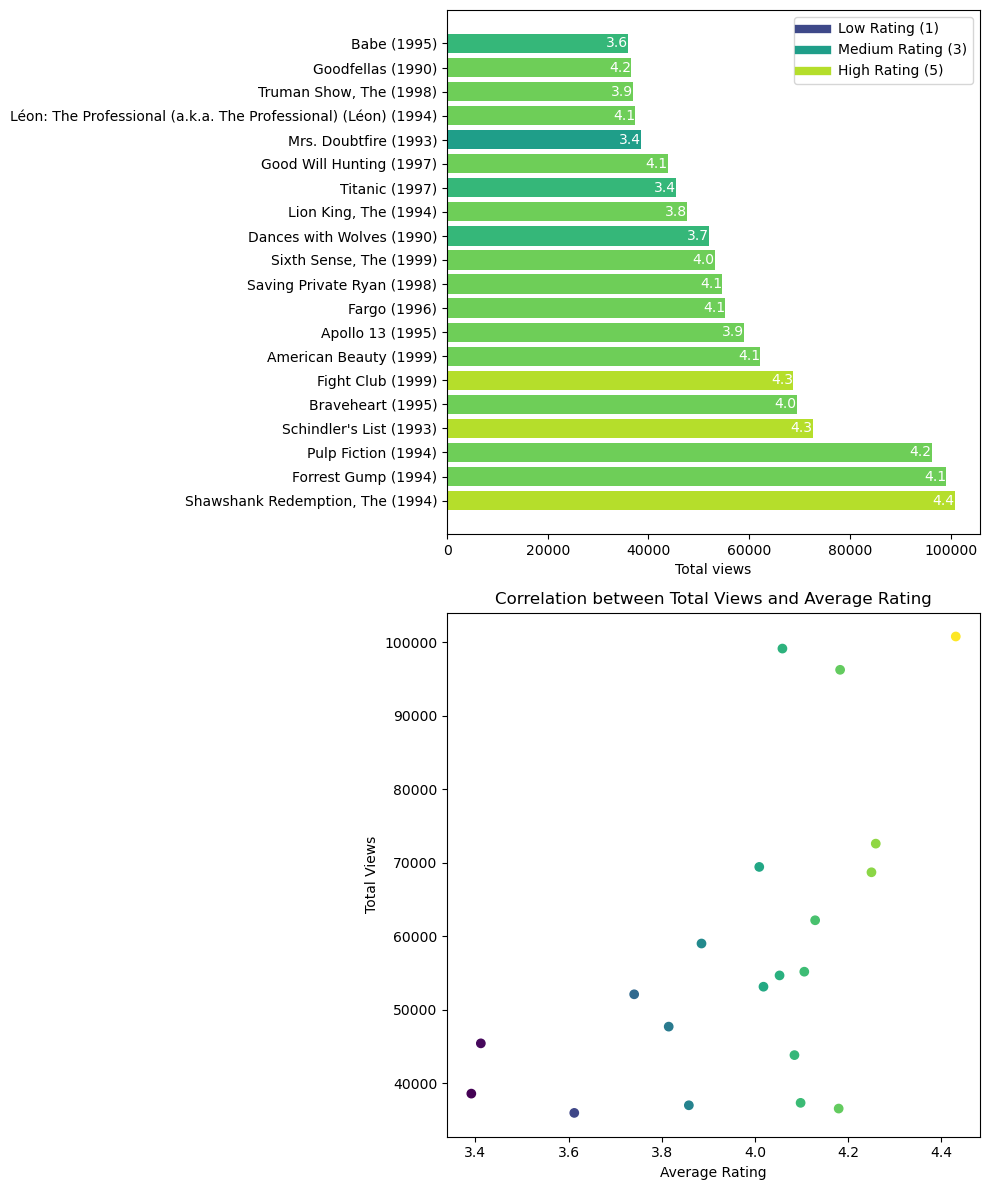

In [277]:
generate_plots(example_agg)

In [191]:
#what is the most popular movie of all time

# top_20_movies_all_time = df_complete.movieId.value_counts().head(20)

count_movies = df_complete.movieId.value_counts()

# sort by movieId
# df_complete.sort_val(by="movieId")




In [140]:
# top_movies = df_complete.copy()

# for movies in top_20_movies_all_time:
#     title = top_movies.loc[top_movies["movieId"] == movies, "title"]
#     print(movies)
#     #Top_20 = pd.DataFrame({'Movie': title, 'count': top})

In [286]:
# count_movies = pd.DataFrame({"total_views": count_movies})

count_movies = pd.DataFrame(count_movies)

count_movies = count_movies.rename(columns={"movieId": "total_views"})

count_movies

rating_means = pd.DataFrame(ratings_df.groupby("movieId")["rating"].mean())

rating_means


,rating
movieId,
1,3.886649
2,3.246583
3,3.173981
4,2.874540
5,3.077291
...,...
193876,3.000000
193878,2.000000
193880,2.000000


In [334]:
movies_df = pd.merge(movies_df, count_movies, left_on="movieId", right_on=count_movies.index)

movies_df = pd.merge(movies_df,  rating_means, on="movieId")

In [254]:
# movies_df["genres_list"] = movies_df["movieId"].map(lambda x : genres_per_movie_dict[x])

# movies_df["genres"] = movies_df["genres"].str.split("|")


In [335]:
movies_df

,movieId,title,genres,total_views,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",68972,3.886649
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",27271,3.246583
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",15595,3.173981
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2991,2.874540
4,5,Father of the Bride Part II (1995),[Comedy],15487,3.077291
...,...,...,...,...,...
53884,193876,The Great Glinka (1946),[(no genres listed)],1,3.000000
53885,193878,Les tribulations d'une caissière (2011),[Comedy],1,2.000000
53886,193880,Her Name Was Mumu (2016),[Drama],1,2.000000
53887,193882,Flora (2017),"[Adventure, Drama, Horror, Sci-Fi]",1,2.000000


Most watched movies of all times

In [370]:
most_watched_df = movies_df.sort_values(by="total_views", ascending=False).head(20)

most_watched_df

,movieId,title,genres,total_views,rating
315,318,"Shawshank Redemption, The (1994)","[Crime, Drama]",100805,4.424188
352,356,Forrest Gump (1994),"[Comedy, Drama, Romance, War]",99162,4.056585
293,296,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",96271,4.173971
587,593,"Silence of the Lambs, The (1991)","[Crime, Horror, Thriller]",89651,4.151412
2487,2571,"Matrix, The (1999)","[Action, Sci-Fi, Thriller]",87652,4.149695
257,260,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",85743,4.120455
476,480,Jurassic Park (1993),"[Action, Adventure, Sci-Fi, Thriller]",77114,3.665034
523,527,Schindler's List (1993),"[Drama, War]",72618,4.257502
108,110,Braveheart (1995),"[Action, Drama, War]",69450,4.008481
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",68972,3.886649


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Shawshank Redemption, The (1994)'),
  Text(1, 0, 'Forrest Gump (1994)'),
  Text(2, 0, 'Pulp Fiction (1994)'),
  Text(3, 0, 'Silence of the Lambs, The (1991)'),
  Text(4, 0, 'Matrix, The (1999)'),
  Text(5, 0, 'Star Wars: Episode IV - A New Hope (1977)'),
  Text(6, 0, 'Jurassic Park (1993)'),
  Text(7, 0, "Schindler's List (1993)"),
  Text(8, 0, 'Braveheart (1995)'),
  Text(9, 0, 'Toy Story (1995)'),
  Text(10, 0, 'Fight Club (1999)'),
  Text(11, 0, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
  Text(12, 0, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
  Text(13, 0, 'Terminator 2: Judgment Day (1991)'),
  Text(14, 0, 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
  Text(15, 0, 'Usual Suspects, The (1995)'),
  Text(16, 0, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
  Text(17, 0, 'American Beauty (1999)'),
  Text(18, 0, 'Godfathe

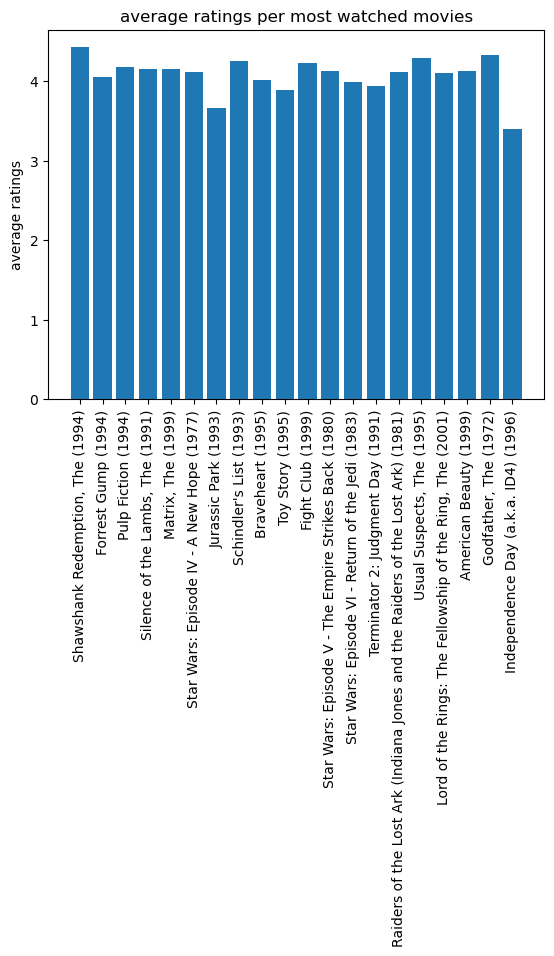

In [373]:
plt.bar(most_watched_df["title"], most_watched_df["rating"])

plt.title("average ratings per most watched movies")
plt.ylabel("average ratings")
plt.xticks(rotation= 90)

In [ ]:
#which genre is rated the highest?

#what is the best combination of genres?


#which

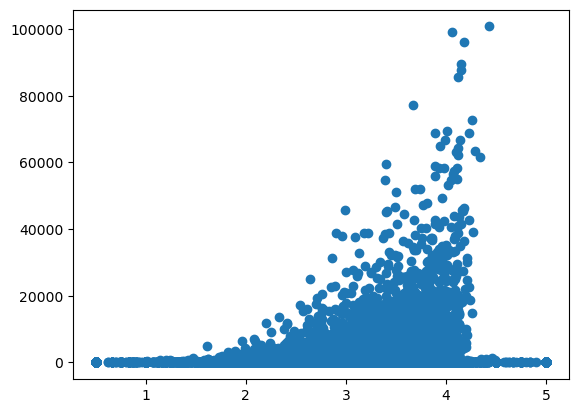

In [197]:
# ratings vs total views

plt.scatter(movies_df["rating"], movies_df["total_views"])

In [257]:
display(movies_df.loc[(movies_df["total_views"] > 50000) & (movies_df["rating"] > 3.8)])

,movieId,title,genres,total_views,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",68972,3.886649
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"[Mystery, Sci-Fi, Thriller]",55995,3.890193
46,47,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",56679,4.071687
49,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",63327,4.291959
108,110,Braveheart (1995),"[Action, Drama, War]",69450,4.008481
148,150,Apollo 13 (1995),"[Adventure, Drama, IMAX]",59028,3.884301
257,260,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",85743,4.120455
293,296,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",96271,4.173971
315,318,"Shawshank Redemption, The (1994)","[Crime, Drama]",100805,4.424188
352,356,Forrest Gump (1994),"[Comedy, Drama, Romance, War]",99162,4.056585


In [339]:
genres_df = movies_df.copy()

# genres_per_movie_df

genres_df = genres_df.explode("genres")

In [328]:
len(movies_df["genres"].unique())

1610

In [350]:
genres_df["genres"].unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [349]:
genres_df[genres_df["total_views"]]

,movieId,title,genres,total_views,rating
16635,83773,Away with Words (San tiao ren) (1999),(no genres listed),2,1.750000
16650,83829,Scorpio Rising (1964),(no genres listed),52,3.607843
16828,84768,Glitterbug (1994),(no genres listed),3,2.833333
17147,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed),2,2.000000
17310,87061,Trails (Veredas) (1978),(no genres listed),4,4.000000
...,...,...,...,...,...
53855,193815,Tempting Fate (1998),(no genres listed),1,3.000000
53870,193849,Rafinha Bastos: Ultimatum (2018),(no genres listed),2,1.750000
53873,193855,"Spring Night, Summer Night (1967)",(no genres listed),1,3.500000
53881,193870,Isabelle Eberhardt (1991),(no genres listed),1,3.000000


Text(0.5, 1.0, 'number of views per genres - all time')

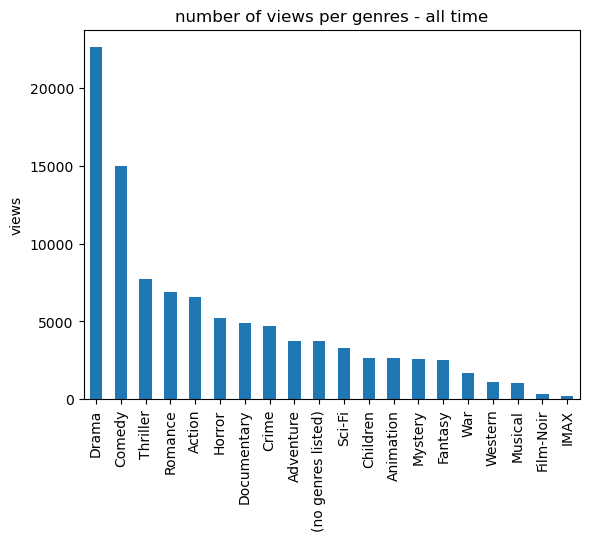

In [357]:
genres_overview_df = genres_df.copy()

genres_overview_df["genres"].value_counts().plot(kind="bar")

plt.ylabel("views")
plt.title("number of views per genres - all time")